# Noise Characterisation Tutorial

The purpose of this tutorial is to demonstrate the basic workflow of the QREM characterization module.


In [1]:
import numpy as np



from typing import Dict, Tuple, List
from qrem.qtypes.characterization_data import CharacterizationData 
from qrem.characterization import characterization
from  qrem.common import probability, math as qrem_math
from qrem.cn import simulation as cnsimulation 
from qrem.providers import simulation as simulate_experiment
from qrem.common.printer import qprint, qprint_array
from qrem.qtypes import CNModelData
from datetime import date
from typing import Tuple, Dict, List, Optional, Type 
from qrem.common.printer import qprint
from qrem.visualisation import benchmark_plots_functions as plot_functions


###List of contents 

1. [Data generation for characterization routine](#Setup)

2. [Analysis of the experimental data](#Characterization)

    2.1 [Initial steps](#Characterization)
   
    2.2 [Marginals computation](#Marginals)
    
    2.3 [Calculation of reduced POVMs and noise matrices](#RPOVMs)
    
    2.4 [Calculation of POVM distances](#POVMsDistances)
      
    2.5 [Calculation of correlation coefficients](#CorrelationCoefficients)

    2.6 [CN noise model reconstruction](#CNnoisereconstruction)
    


<a id='Setup'></a>

## Data generation for characterization routine

This part of code is used to generate data for the characterization workflow. It uses QREM simulator of the readout noise.

In [2]:

number_of_qubits = 10

experiment_type = "DDOT"

number_of_circuits = 200

number_of_shots = 10**4

include_benchmark_circuits = False

number_of_benchmark_circuits = 10

number_of_3_qubit_clusters = 1

number_of_2_qubit_clusters = 3

number_of_1_qubit_clusters = 1

noise_model_simulation=cnsimulation.create_random_noise_model(number_of_qubits=number_of_qubits,clusters_specification=[[3,number_of_3_qubit_clusters], [2, number_of_2_qubit_clusters], [1, number_of_1_qubit_clusters]])

characterization_data_container = CharacterizationData()

characterization_data_container.experiment_type = 'DDOT' 

characterization_data_container.results_dictionary = simulate_experiment.simulate_noisy_experiment(noise_model=noise_model_simulation,number_of_circuits=number_of_circuits,number_of_shots=number_of_shots).counts


10
completeness: True
Adding 190 random circuits to a 10-element set
Set of 200 circuits, completeness: True
noisy results generated in: 8.549237251281738 seconds


<a id='Characterization'></a>

## Characterization Routine 


### Initial steps 

To perform characterization one needs to specify:

1. qubit_indices - a list of indices of qubits of interest (one might be interested in a subset of all qubits of a device). Here we are interested in all qubits.

2. marginals_to_compute - a list of tuples encoding qubit marginals for which relevant noise quantifiers are computed. Here the focus is on at most two qubit quantities and the list is as composition of single- and two-qubit marginals. 


In [3]:
qubit_indices = [i for i in range(number_of_qubits)]

single_qubit_marginals = [(i,) for i in range(number_of_qubits)]

two_qubit_marginals = [(i, j) for i in range(number_of_qubits) for j in range(i + 1, number_of_qubits)]

marginals_to_compute= single_qubit_marginals + two_qubit_marginals

<a id='Marginals'></a>

### Marginals coputation

Marginals computation is performed using compute_marginals_single function of probability submodule. One needs to specify:


1. results_dictionary - dictionary storing experimental results. Here it is characterization_data_container.results_dictionary.

2. subsets_list - a list of tuples encoding marginals of interest. Here set to marginals_to_compute. 

3. normalization - a bool specifying whether marginals are normalized. Here set to True. 

In [4]:
characterization_data_container.marginals_dictionary = probability.compute_marginals_single(results_dictionary=characterization_data_container.results_dictionary,subsets_list=marginals_to_compute,normalization=True)

<a id='RPOVMs'></a>

### Computation of reduced POVMs and nosie matrices 

Computation of the reduced POVMs and noise matrices is performed using compute_reduced_POVMs_and_noise_matrices. One needs to specify:

1. characterization_data - results and marginals data stored in an object of the CharacterizationData class, here characterization_data_container

2. subset_of_qubits - list of marginals of interest, here marginals_to_compute 

In [5]:

   
noise_matrices_dictionary, POVMs_dictionary = characterization.compute_reduced_POVMs_and_noise_matrices(characterization_data=characterization_data_container,subset_of_qubits=marginals_to_compute)


characterization_data_container.POVMs_dictionary = POVMs_dictionary


characterization_data_container.noise_matrices_dictionary = noise_matrices_dictionary

100%|██████████| 55/55 [00:00<00:00, 3993.54it/s]


<a id='POVMsDistances'></a>

### Computation of POVMs errors

Distance computation between ideal projectors in the computational basis and reconstructed noisy reduced POVMs is computed by compute_errors_POVMs function. One needs to specify:

1. POVMs_dictionary - dictionary with reconstructed POVMs, here characterization_data_container.POVMs_dictionary

2. qubits_subsets - list of tuples encoding marginals of interest, here set to single_qubit_marginals  

3. distances_types - a list of tuples encoding distances of interest. Possible choices
    
    first position:  "worst_case" and "averaged_case" 

    second position: "classical" and "quantum"

    Here set to ('worst_case','classical')


In [6]:
distances_types = [('worst_case','classical')] 

characterization_data_container.POMVs_errors_dictionary = characterization.compute_errors_POVMs(POVMs_dictionary=characterization_data_container.POVMs_dictionary,qubits_subsets=single_qubit_marginals,distances_types=distances_types)



Calculating errors of type: ('worst_case', 'classical')


100%|██████████| 10/10 [00:00<00:00, 12756.40it/s]

DONE


The results can be plotted using built-in visualization function

/home/tuzjan/Documents/QREM_DEVELOPMENT/QREM_SECRET_DEVELOPMENT/venv_jtdev/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6805: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


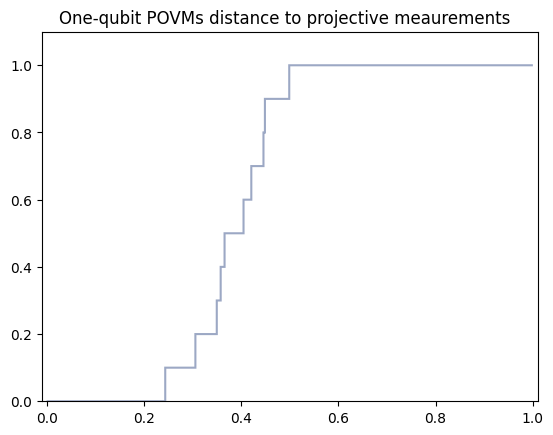

<Figure size 640x480 with 0 Axes>

In [7]:
plot_functions.create_POVMs_distance_histogram(POVMs_errors=characterization_data_container.POMVs_errors_dictionary,number_of_qubits=number_of_qubits)

<a id='CorrelationCoefficients'></a>

### Computation of correlation coefficients

Correlation coefficients, which quantify pairwise correlations in the readout noise, are computed using compute_correlations_data_pairs function. One needs to specify:

 1. qubit_indices - a list of qubits of interest. Here set to qubit_indices, this is all qubits

 2. POVMs_dictionary - dictionary with reconstructed POVMs, here characterization_data_container.POVMs_dictionary

 3. distances_types - a list of tuples encoding distances of interest. Possible choices described above

    Here set to ('worst_case','classical')

In [8]:
characterization_data_container.correlation_coefficients_dictionary  = characterization.compute_correlations_data_pairs(qubit_indices=qubit_indices,POVMs_dictionary=characterization_data_container.POVMs_dictionary,distances_types=distances_types)



Calculating correlations of type: ('worst_case', 'classical')


100%|██████████| 45/45 [00:00<00:00, 2477.44it/s]

DONE


The results can be plotted using built-in visualization function

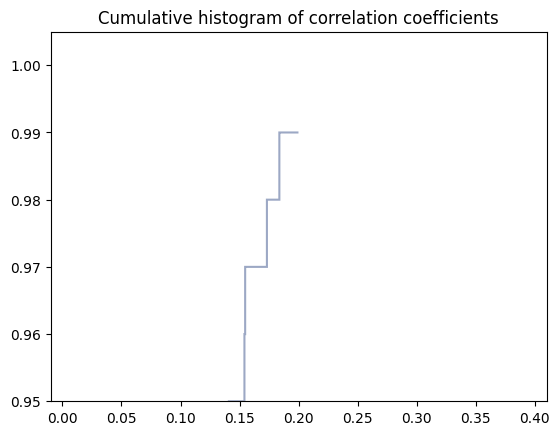

<Figure size 640x480 with 0 Axes>

In [9]:
plot_functions.create_correlations_distance_histogram(correlations_coefficients_matrix=characterization_data_container.correlation_coefficients_dictionary[distances_types[0][0]][distances_types[0][1]])

<a id='CNnoisereconstruction)'></a>

### CN noise models reconstruction 

Clustering algorithm is run to reconstruct CN noise models from experimental data. Function perform_clustering_routine returns a list of object, which store all relevant parameters of the reconstructed CN noise models. One needs to specify:

1. characterization_data - characterization_data - results and marginals data stored in an object of the CharacterizationData class, here characterization_data_container

2. number_of_qubits - integer encoding number of qubits involved 

3. clustering_functions_parameters  - a dictionary specifying parameters of the clustering algorithm with keys:
     
     'sizes_clusters' - a list of integers specifying allowed localities of the CN noise models, here set to [2,3,4]
     
     'distance_type' and 'correlations_type'  - string encoding distance type used to compute correlation coefficients, here  'worst_case' and 'classical'
     
     'alpha_hyperparameters' - a list of floats encoding parameter entering optimization involved in clustering, here and by default set [0] }

4. find_neighbors - bool specifying whether neighborhoods of clusters are established, here set to False 



In [10]:
clustering_functions_parameters = {'sizes_clusters':[2,3,4],'distance_type':'worst_case','correlations_type': 'classical','alpha_hyperparameters': [0] }

find_neighbors = False

characterization_data_container.clusters_neighbors_sets_dictionary = characterization.perform_clustering_routine(characterization_data = characterization_data_container, number_of_qubits=number_of_qubits,clustering_functions_parameters = clustering_functions_parameters,perform_neighbors_search=find_neighbors)




Current max cluster size: 2

Current max cluster size: 3

Current max cluster size: 4
